In [1]:
import math, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
# from caas_jupyter_tools import display_dataframe_to_user

In [2]:
random.seed(42)
np.random.seed(42)

ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

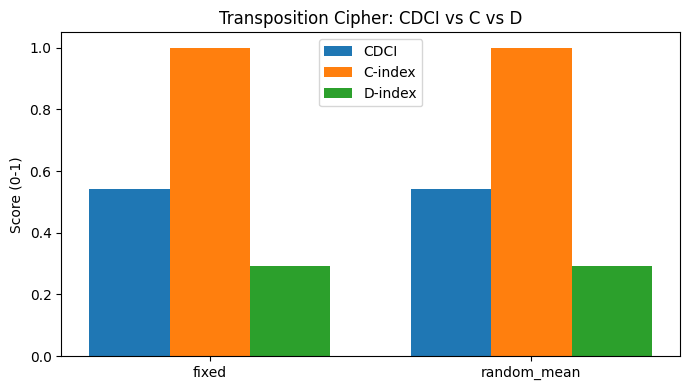

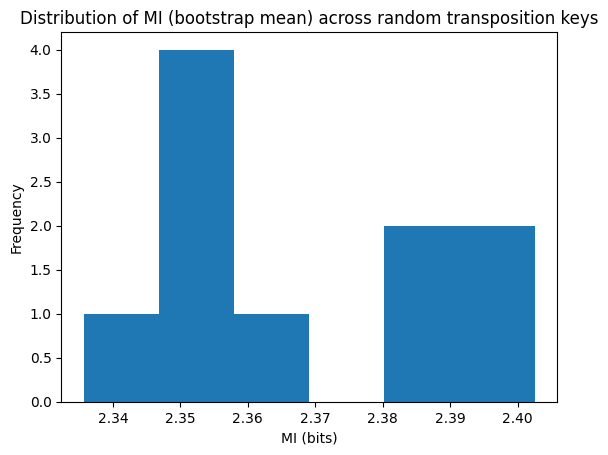

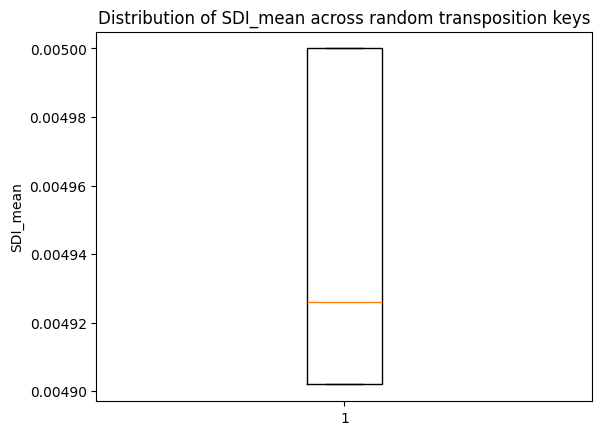

CSV files saved: transposition_cipher_fixed.csv, transposition_cipher_random.csv, transposition_cipher_summary.csv


In [4]:
# ---------------- Columnar Transposition Cipher ----------------
def columnar_transposition_encrypt(text, key):
    text = "".join(ch for ch in text.upper() if 'A' <= ch <= 'Z')
    n = len(key)
    rows = (len(text)+n-1)//n
    padded = text + "X"*(rows*n-len(text))
    matrix = [padded[i*n:(i+1)*n] for i in range(rows)]
    order = sorted(range(n), key=lambda i: key[i])
    ciphertext = "".join("".join(row[j] for row in matrix) for j in order)
    return ciphertext

def random_trans_key(min_len=4, max_len=7):
    length = random.randint(min_len,max_len)
    return "".join(random.choice(ALPHABET) for _ in range(length))

def perturb_trans_key(key):
    k = list(key)
    i,j = random.sample(range(len(k)),2)
    k[i],k[j]=k[j],k[i]
    return "".join(k)

# ---------------- Metric Functions (reuse) ----------------
def fraction_changed(a, b):
    return sum(x!=y for x,y in zip(a,b)) / len(a)

def symbol_diffusion_index(cipher_func, plaintext, key, alphabet, trials=10):
    L = len(plaintext)
    C = cipher_func(plaintext, key)
    results = []
    for _ in range(trials):
        i = random.randrange(L)
        new_char = random.choice([c for c in alphabet if c != plaintext[i]])
        P2 = plaintext[:i]+new_char+plaintext[i+1:]
        C2 = cipher_func(P2, key)
        results.append(fraction_changed(C, C2))
    return np.mean(results), np.std(results)

def compute_ksi(cipher_func, plaintext, key, key_variant):
    C = cipher_func(plaintext, key)
    C2 = cipher_func(plaintext, key_variant)
    return fraction_changed(C, C2)

def mutual_information(pairs):
    N = len(pairs)
    joint = Counter(pairs)
    X_counts = Counter(x for x,_ in pairs)
    Y_counts = Counter(y for _,y in pairs)
    mi = 0.0
    for (x,y), n in joint.items():
        p_xy = n/N
        p_x = X_counts[x]/N
        p_y = Y_counts[y]/N
        mi += p_xy * math.log2(p_xy/(p_x*p_y))
    return mi

def compute_mi_from_plain_cipher_lists(plain_list, cipher_list):
    pairs = list(zip("".join(plain_list), "".join(cipher_list)))
    return mutual_information(pairs)

def compute_chi_entropy(ciphertexts, alphabet):
    text = "".join(ciphertexts)
    N = len(text)
    counts = Counter(text)
    expected = N/len(alphabet)
    chi2 = sum((counts[a]-expected)**2/expected for a in alphabet)
    entropy = -sum((counts[a]/N)*math.log2(counts[a]/N) for a in counts if counts[a]>0)
    return chi2, entropy

def bootstrap_mi(pairs, n_boot=200, alpha=0.05):
    estimates=[]
    N = len(pairs)
    for _ in range(n_boot):
        sample = [pairs[random.randrange(N)] for _ in range(N)]
        mi = mutual_information(sample)
        estimates.append(mi)
    estimates.sort()
    low = estimates[int((alpha/2)*n_boot)]
    high= estimates[int((1-alpha/2)*n_boot)]
    return np.mean(estimates), (low,high)

# ---------------- CDCI ----------------
def confusion_index(cipher_func, plaintext, keyspace, samples=100):
    pairs = []
    for _ in range(samples):
        k = random.choice(keyspace)
        c = cipher_func(plaintext, k)
        for sym in c:
            pairs.append((str(k), sym))
    mi = mutual_information(pairs)
    H_K = math.log2(len(keyspace))
    C = 1 - (mi / H_K if H_K>0 else 0)
    return max(0, min(1, C))

def ciphertext_entropy_one(cipher_func, plaintext, key):
    C = cipher_func(plaintext, key)
    chi2, Hc = compute_chi_entropy([C], ALPHABET)
    return Hc

def diffusion_index(cipher_func, plaintext, key, alphabet, alpha=0.7, trials=10):
    sdi_mean, sdi_std = symbol_diffusion_index(cipher_func, plaintext, key, alphabet, trials)
    Hc = ciphertext_entropy_one(cipher_func, plaintext, key)
    norm_H = Hc / math.log2(len(alphabet))
    D = alpha*sdi_mean + (1-alpha)*norm_H
    return D, sdi_mean, sdi_std, norm_H

def cdci_score(cipher_func, plaintext, key, keyspace, alphabet, alpha=0.7):
    C = confusion_index(cipher_func, plaintext, keyspace)
    D, sdi_mean, sdi_std, norm_H = diffusion_index(cipher_func, plaintext, key, alphabet, alpha=alpha)
    return math.sqrt(C*D), C, D, sdi_mean, sdi_std, norm_H

# ---------------- Experiment ----------------
num_texts = 5
length = 200
plaintexts = ["".join(random.choice(ALPHABET) for _ in range(length)) for _ in range(num_texts)]
plaintexts[0] = ("THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG" * 6)[:length]

fixed_key = "ZEBRAS"
random_key_count = 10
random_keys = [random_trans_key() for _ in range(random_key_count)]
keyspace_for_confusion = [random_trans_key() for _ in range(50)]

# --- Mode A: Fixed Key ---
fixed_results = {}
sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; entropy_vals=[]; mi_boot_means=[]; mi_boot_cis=[]
for pt in plaintexts:
    sdi_mean,_ = symbol_diffusion_index(columnar_transposition_encrypt, pt, fixed_key, ALPHABET, trials=20)
    sdi_vals.append(sdi_mean)
    ksi_vals.append(compute_ksi(columnar_transposition_encrypt, pt, fixed_key, perturb_trans_key(fixed_key)))
    Ctext = columnar_transposition_encrypt(pt, fixed_key)
    mi_vals.append(compute_mi_from_plain_cipher_lists([pt],[Ctext]))
    chi2,Hc = compute_chi_entropy([Ctext], ALPHABET)
    chi_vals.append(chi2); entropy_vals.append(Hc)
    mean_boot, ci = bootstrap_mi(list(zip(pt,Ctext)), n_boot=100)
    mi_boot_means.append(mean_boot); mi_boot_cis.append(ci)

fixed_results['SDI_mean']=np.mean(sdi_vals)
fixed_results['KSI_mean']=np.mean(ksi_vals)
fixed_results['MI_mean']=np.mean(mi_vals)
fixed_results['Chi2_mean']=np.mean(chi_vals)
fixed_results['Entropy_mean']=np.mean(entropy_vals)
fixed_results['MI_boot_mean']=np.mean(mi_boot_means)
fixed_results['MI_boot_CI_low']=np.mean([ci[0] for ci in mi_boot_cis])
fixed_results['MI_boot_CI_high']=np.mean([ci[1] for ci in mi_boot_cis])
fixed_cdci,fixed_C,fixed_D,_,_,_ = cdci_score(columnar_transposition_encrypt, plaintexts[0], fixed_key, keyspace_for_confusion, ALPHABET)
fixed_results['CDCI']=fixed_cdci; fixed_results['C_index']=fixed_C; fixed_results['D_index']=fixed_D

fixed_df = pd.DataFrame([fixed_results])

# --- Mode B: Random Keys ---
random_mode_results=[]
for rk in random_keys:
    sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; entropy_vals=[]; mi_boot_means=[]
    for pt in plaintexts:
        sdi_mean,_ = symbol_diffusion_index(columnar_transposition_encrypt, pt, rk, ALPHABET, trials=12)
        sdi_vals.append(sdi_mean)
        ksi_vals.append(compute_ksi(columnar_transposition_encrypt, pt, rk, perturb_trans_key(rk)))
        Ctext=columnar_transposition_encrypt(pt,rk)
        mi_vals.append(compute_mi_from_plain_cipher_lists([pt],[Ctext]))
        chi2,Hc=compute_chi_entropy([Ctext],ALPHABET)
        chi_vals.append(chi2); entropy_vals.append(Hc)
        mean_boot,_=bootstrap_mi(list(zip(pt,Ctext)),n_boot=80)
        mi_boot_means.append(mean_boot)
    CDCI,C,D,_,_,_ = cdci_score(columnar_transposition_encrypt, plaintexts[0], rk, keyspace_for_confusion, ALPHABET)
    random_mode_results.append({
        'key':rk,'SDI_mean':np.mean(sdi_vals),
        'KSI_mean':np.mean(ksi_vals),'MI_mean':np.mean(mi_vals),
        'Chi2_mean':np.mean(chi_vals),'Entropy_mean':np.mean(entropy_vals),
        'MI_boot_mean':np.mean(mi_boot_means),'CDCI':CDCI,'C_index':C,'D_index':D
    })
random_df=pd.DataFrame(random_mode_results)

summary=pd.DataFrame({
    'mode':['fixed','random_mean'],
    'SDI_mean':[fixed_results['SDI_mean'],random_df['SDI_mean'].mean()],
    'KSI_mean':[fixed_results['KSI_mean'],random_df['KSI_mean'].mean()],
    'MI_mean':[fixed_results['MI_mean'],random_df['MI_mean'].mean()],
    'Entropy_mean':[fixed_results['Entropy_mean'],random_df['Entropy_mean'].mean()],
    'CDCI':[fixed_results['CDCI'],random_df['CDCI'].mean()],
    'C_index':[fixed_results['C_index'],random_df['C_index'].mean()],
    'D_index':[fixed_results['D_index'],random_df['D_index'].mean()],
})

# ---------------- Outputs ----------------
# display_dataframe_to_user("Transposition Cipher - Fixed Key Results", fixed_df)
# display_dataframe_to_user("Transposition Cipher - Random Keys Results", random_df)
# display_dataframe_to_user("Transposition Cipher - Summary", summary)

# Plots
labels=summary['mode']; x=np.arange(len(labels)); width=0.25
fig,ax=plt.subplots(figsize=(7,4))
ax.bar(x-width,summary['CDCI'],width,label='CDCI')
ax.bar(x,summary['C_index'],width,label='C-index')
ax.bar(x+width,summary['D_index'],width,label='D-index')
ax.set_xticks(x); ax.set_xticklabels(labels); ax.set_ylabel('Score (0-1)')
ax.set_title('Transposition Cipher: CDCI vs C vs D'); ax.legend(); plt.tight_layout(); plt.show()

plt.hist(random_df['MI_boot_mean'],bins=6)
plt.title('Distribution of MI (bootstrap mean) across random transposition keys')
plt.xlabel('MI (bits)'); plt.ylabel('Frequency'); plt.show()

plt.boxplot(random_df['SDI_mean'].dropna())
plt.title('Distribution of SDI_mean across random transposition keys')
plt.ylabel('SDI_mean'); plt.show()

# Save CSVs
fixed_df.to_csv('./data/transposition_cipher_fixed.csv',index=False)
random_df.to_csv('./data/transposition_cipher_random.csv',index=False)
summary.to_csv('./data/transposition_cipher_summary.csv',index=False)
print("CSV files saved: transposition_cipher_fixed.csv, transposition_cipher_random.csv, transposition_cipher_summary.csv")

In [5]:
fixed_df

,SDI_mean,KSI_mean,MI_mean,Chi2_mean,Entropy_mean,MI_boot_mean,MI_boot_CI_low,MI_boot_CI_high,CDCI,C_index,D_index
0,0.004902,0.327451,1.819293,32.854902,4.587506,2.34247,2.193719,2.493919,0.541069,0.999757,0.292827


In [6]:
random_df

,key,SDI_mean,KSI_mean,MI_mean,Chi2_mean,Entropy_mean,MI_boot_mean,CDCI,C_index,D_index
0,UAKMQU,0.004902,0.319608,1.833839,32.854902,4.587506,2.351739,0.541071,0.999762,0.292827
1,KUER,0.005000,0.482000,1.924808,32.232000,4.588866,2.402511,0.540971,0.999768,0.292718
2,MNIJBR,0.004902,0.313725,1.847978,32.854902,4.587506,2.364008,0.541069,0.999755,0.292827
3,LYCHZSG,0.004926,0.275862,1.833036,32.332020,4.588969,2.355256,0.541117,0.999756,0.292879
4,FFHOGZ,0.004902,0.305882,1.882859,32.854902,4.587506,2.383075,0.541069,0.999756,0.292827
5,LQUIRD,0.004902,0.325490,1.820138,32.854902,4.587506,2.335703,0.541071,0.999764,0.292827
6,KAXTLTN,0.004926,0.335961,1.821616,32.332020,4.588969,2.349043,0.541119,0.999763,0.292879
7,GENBK,0.005000,0.390000,1.835953,32.232000,4.588866,2.351386,0.540969,0.999758,0.292718
8,LFCM,0.005000,0.488000,1.918708,32.232000,4.588866,2.399954,0.540973,0.999775,0.292718
9,YEPP,0.005000,0.585000,1.886444,32.232000,4.588866,2.385052,0.540968,0.999756,0.292718


In [7]:
summary

,mode,SDI_mean,KSI_mean,MI_mean,Entropy_mean,CDCI,C_index,D_index
0,fixed,0.004902,0.327451,1.819293,4.587506,0.541069,0.999757,0.292827
1,random_mean,0.004946,0.382153,1.860538,4.588342,0.541040,0.999761,0.292794
